# Car Price prediction

## Прогнозирование стоимости автомобиля по характеристикам

## В baseline было сделано:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

## Что я добавила:
* ProfileReport
* Обработку выбросов
* Парсинг колонок 
* Добавила новые фичи
* Все собрала в одну функцию 
* Улучшила результаты CatBoost 


## Что можно сделать еще:
* Обработать Владение и name
* Воспользоваться сервисом neptune для сравнения экспериментов

In [6]:
#аугментации изображений
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [65]:
import albumentations as A

In [5]:
!pip install catboost==0.26

     |████████████████████████████████| 69.2 MB 22 kB/s  eta 0:00:012     |████████████████████████████▎   | 61.2 MB 5.4 MB/s eta 0:00:02     |████████████████████████████▋   | 61.9 MB 5.4 MB/s eta 0:00:02     |█████████████████████████████   | 62.8 MB 5.4 MB/s eta 0:00:02
  Attempting uninstall: catboost
    Found existing installation: catboost 0.24
    Uninstalling catboost-0.24:
      Successfully uninstalled catboost-0.24
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
# import cv2
import re
# import pandas_profiling
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# import albumentations

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

pd.set_option('display.max_columns', None)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)


Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.info()

In [ ]:
train.nunique()

Большинство колонок с категориальным типом, еще 5 колонки - целочисленные (modelDate, numberOfDoors, productionDate, sell_id, mileage), оставщаяся 1 колонка - вещественная (price).

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [9]:
# split данных
data_train, data_test = train_test_split(
    train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [10]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info',
                                          'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%"
)

Точность наивной модели по метрике MAPE: 19.88%


# EDA

In [ ]:
!pip install pandas_profiling==3.0.0

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
# проведем быстрый анализ переменных
profile = ProfileReport(train, title="Pandas Profiling Report")

In [ ]:
profile

## Выводы по Pandas Profiling

Общее количество пропущенных значений - 4327 ячеек, что составляет 2.9% от всего числа. Пропущенных значений достаточно мало.

Pandas Profiling не обнаружил дублирующихся ячеек.

Представлено 17 категориальных переменных и 5 числовых.

1. bodyType - сейчас представлено 17 разных вариантов кузова автомобиля. Но распределение смещено в сторону седан и внедорожник 5 дв, их больше всего. Попробовать объединить оставшееся значения и потом кодировать.
2. brand - пропусков нет, всего три значения (BMW, MERCEDES, AUDI) - закодировать их в числа.
3. color - преобладает черный, белый, серый и синий цвет. Остальные попробовать объединить
4. description - содержит текстовое описание, буду обрабатывать с помощью моделей NLP.
5. engineDisplacement - убрать 'LTR'. Преобладают значения 2.0 и 3.0. Объем двигателя.
6. enginePower - убрать 'N12'. Большой разброс значений. Можно попробовать объединить их в группы от и до. Мощность двигателя.
7. fuelType - 4 значения, остается их закодировать.
8. mileage - распределение смещено к началу координат, надо нормализовать. Минимальное значение - 1, максимальное - 999999. Скорее всего максимальное - это выброс, проверить.
9. modelDate - распределение смещено к концу координат, а это значит, что больше машин современных 2005 года и старше. Минимальное значение - 1975 год.
10. model_info - название модели. 5ER, 3ER, E_KLASSE, X5, A6
11. name - сборная информация по разным параметрам -  530xi 3.0 AT (272 л.с.) 4WD. Объем двигателя и мощность двигателя дублируется - можно удалить. Остается привод, коробка передач. Пока не поняла про первое значение.
12. numberOfDoors - больше всего машин с 5 и 4 дверьми. 2 и 3 двери составляют 10% от общего числа автомобилей.
13. price - целевая переменная. Минимальное значение - 301301, максимальное значение - 23900000. Распределение смещено.
14. productionDate - минмальное значение - 1982, максимальное - 2020.
15. sell_id - хранится информация о изображении автомобиля.
16. vehicleConfiguration - текстовое описание. Например, SEDAN AUTOMATIC 3.0, SEDAN VARIATOR 2.8, SEDAN AUTOMATIC 3.5, LIFTBACK VARIATOR 1.8.
17. vehicleTransmission - автоматическая, роботизированная,  вариатор и механическая. Попробовать объединить в два вида - автомат и механику.
18. Владельцы - есть пропуски, нужно привести в числовой вид - 1, 2 или 3.
19. Владение - больше половины пропущенных значений. Строки выглядят -  1 год и 8 месяцев, 1 год и 2 месяца, 9 месяцев. Привести в числовой вид.
20. ПТС - большая часть значений - Оригинал. Привести в числовой вид.
21. Привод - пропусков нет. Полный, задний, передний.
22. Руль - только два значения с левым рулем. Можно попробовать удалить.

Видим высокую корреляцию (по коэффициенту Пирсона) между modelDate и productionDate. И обратную корреляцию между productionDate, modelDate и mileage. В этом есть смысл - чем моложе машина, тем меньше у нее пробег. 

Если смотреть на корреляцию Phi_K, то можно заметить связь между engineDisplacement и fuelType, bodyType и numberOfDoors.

In [11]:
# проверим на дубликаты
train.duplicated().value_counts()

False    6682
dtype: int64

In [ ]:
# let's look at the values ​​in the columns
train.sample(3)

## Сделаем базовую предобработку

На основании информации из профайла, сделаем базовую предобработку колонок, где есть лишние артефакты.

In [ ]:
# Remove units and converting to number (values like '2.0 LTR')
regex = re.compile(r"\sLTR\s*", re.IGNORECASE)
train['engineDisplacement'] = train['engineDisplacement'].apply(
    lambda x: re.sub(regex, '', x))
train['engineDisplacement'] = train['engineDisplacement'].apply(
    pd.to_numeric, errors='coerce')

In [ ]:
# Remove units and converting to number (values like '249 N12')
train['enginePower'] = train['enginePower'].apply(
    lambda x: x if (type(x) == int or x is None) else None
    if (x == ' N12') else int(x.replace(' N12', '').strip()))

In [ ]:
# Convert data type
train['productionDate'] = train['productionDate'].astype('int')

In [ ]:
# Remove artifacts like ' 5 дв.' in values like 'внедорожник 5 дв.'
regex = re.compile(r"\s\d\sдв\.\s*", re.IGNORECASE)
train['bodyType'] = train['bodyType'].apply(lambda x: re.sub(regex, '', x))

In [ ]:
train.info()

In [ ]:
# проверяем пустые значения
print('Proportion of nan per column')
print(train.isnull().sum() / train.shape[0])

Проопуски нужно будет обработать для граф Владельцы и Владение. Также появились пропуски в колонке 'engineDisplacement', после того, как распарсила ее.

### Владельцы

In [ ]:
# посмотрим на график
for col in ['Владельцы']:
    sns.countplot(y=train[col])
    plt.show()

In [ ]:
train.Владельцы.value_counts(dropna=False)

Больше всего машин, у которых 3 владельца и более. И только одно значение пропущенно. Посмотрим на него.

In [ ]:
# смотрим на пропущенное значение
train[train['Владельцы'].isna()]

In [ ]:
# только одно значение пропущено - заменяем на наиболее частотное
train['Владельцы'] = train['Владельцы'].fillna('3 или более')

In [ ]:
# Remove non-numbers (in values like '3 или более')
regex = re.compile(r"\D+")
train['Владельцы'] = train['Владельцы'].apply(
    lambda x: int(re.sub(regex, '', x)))

## Владение

In [ ]:
# в колонке Владение пропусков больше половины
train.Владение.value_counts(dropna=False)

В колонке Владение пропусков больше половины - можно попробовать заполнить их разницей от даты производства.

## Проверка на выбросы

In [ ]:
def outliers_detection_IQR(data, col):

    # print min, max values, outlier boundaries, and proportion of outliers
    # return oulier boundaries

    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    IQR = perc75 - perc25
    left = perc25 - 1.5 * IQR
    right = perc75 + 1.5 * IQR
    print(col+' feature')
    print('min: {0}, max: {1}'.format(data[col].min(), data[col].max()))
    print('outlier boundaries: [{0}, {1}]'.format(left, right))
    if len(data[~data[col].between(left, right)]) > 0:
        print('ratio of outliers: {}'.format(
            len(data[(~data[col].between(left, right)) & (~data[col].isna())])/len(data)))
        print('\n')

    return left, right

In [ ]:
outliers_detection_IQR(train, 'engineDisplacement')

In [ ]:
train['engineDisplacement'].value_counts(bins=6).plot.barh()

In [ ]:
mode = train['engineDisplacement'].mode()[0]
print("Самое частое значение в поле engineDisplacement: ", mode)

In [ ]:
# заполним пропуски модой
train['engineDisplacement'].fillna(mode, inplace=True)

Вывод min: 0.7, max: 6.6

In [ ]:
outliers_detection_IQR(train, 'enginePower')

In [ ]:
train['enginePower'].value_counts(bins=6).plot.barh()

Максимальная мощность 639 л.с. и минимальная - 75 л.с. Выбросов согласно методу IQR около 6%. На графике видем, что больше всего машин с мощностью 169 - 263 л.с.

In [ ]:
# до этого мы убрали артефакты подобные "5 дв"
for col in ['bodyType']:
    sns.countplot(y=train[col])
    plt.show()

`fuelType`, `numberOfDoors`, `vehicleTransmission`, `ПТС` & `Привод`

In [ ]:
for col in ['fuelType', 'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод']:
    sns.countplot(y=train.fillna('nan_')[col])
    plt.show()

Попробую создать новый признак на основе vehicleTransmission. Также можно объединить гибрид и электро в fuelType, так как слишком мало значений. 

In [ ]:
# create a new column, in which we will combine the variator, robotic and automatic transmission
train['vehicleTransmission_combined'] = train['vehicleTransmission'].replace(
    ['вариатор', 'роботизированная'], 'автоматическая')

`bodyType`, `color`, `Владельцы` & `Руль`

In [ ]:
for col in ['bodyType', 'color', 'Владельцы', 'Руль']:
    sns.countplot(y=train[col])
    plt.show()

1. Руль - бинарный признак с слишком большим количеством значений одного типа - проверить насколько значим признак и если нет - удалить.
2. color u bodytype - много классов, большинство из которых содержат очень мало примеров. На этапе обработки выделим несколько самых популярных классов, остальные объединим.

In [ ]:
# we take the ten most popular body options
bodyType = train.bodyType.value_counts().head(10)
# everything that does not fall into the bodyType is moved to the category 'other'
train['bodyType_other'] = train.bodyType
train['bodyType_other'] = train['bodyType_other'].apply(
    lambda x: x if x in bodyType else 'другой')

In [ ]:
# check
train.bodyType.value_counts()

In [ ]:
# check
train.bodyType_other.value_counts()

In [ ]:
# by analogy we do for the color column
# combine golden, purple, violet, orange, yellow and pink
color = train.color.value_counts().head(10)
train['color_other'] = train.color
train['color_other'] = train['color_other'].apply(
    lambda x: x if x in color else 'другой')

`brand`

In [ ]:
train['brand'].value_counts()

Больше всего представлено машин под маркой BMW. Пропусков нет, оставляем в том же состоянии.

`mileage` & `productionDate`

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(['mileage', 'productionDate']):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [ ]:
outliers_detection_IQR(train, 'mileage')
outliers_detection_IQR(train, 'productionDate')

Распределение смещены. Выбросов порядка 2%. Пока выбросы не удаляем, при обучении моделей попробуем логарифмировать признак.

In [ ]:
data['mileage'].describe()

`name`

In [97]:
# отметим машины, у которых есть постоянный полный привод
train['4wd'] = train['name'].apply(lambda x: 1 if '4WD' in x else 0)
train['4wd'].value_counts()

1    4189
0    2493
Name: 4wd, dtype: int64

In [98]:
# отметим машины с системой полного привода от BMW
data['xdrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
data['xdrive'].value_counts()

0    7414
1     939
Name: xdrive, dtype: int64

`price` - целевая переменная

In [ ]:
sns.distplot(train['price'], kde=False)

In [ ]:
left_price, right_price = outliers_detection_IQR(train, 'price')

Максимальная стоимость в 23,9 миллиона, минимальная - 301 тысяча. Выбросов согласно методу IQR около 7%. Ниже на графике видем, что основная часть значений лежит в промежутке от 277 тыс до 4,233 млн.

In [ ]:
train["price"].value_counts(bins=6).plot.barh()

In [ ]:
# посмотрим на распределение числовых признаков
fig, axes = plt.subplots(3, 4, figsize=(25, 12))
for col, i in zip(numerical_features, range(12)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Видим, что у 'engineDisplacement', 'enginePower', 'mileage', 'modelDate' расперделение смещено. В дальнейшем их можно логорифмировать.

In [ ]:
# логорифмируем
log_num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate']
for i in log_num_cols:
    data[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10, 6))
    sns.distplot(data[i][data[i] > 0].dropna(), kde=False, rug=False)
    plt.show()

## Feature engineering

`mileage` -> `mileage_category`

In [12]:
# попробуем разбить пробег по категориям и ввести новый признак
# предполагаем, что чем меньше км, тем лучше
def mile_age(x):
    if x < 25000:
        x = 1
    elif 24999 < x < 50000:
        x = 2
    elif 49999 < x < 75000:
        x = 3
    elif 74999 < x < 100000:
        x = 4
    elif 99999 < x < 150000:
        x = 5
    elif 149999 < x < 200000:
        x = 6
    elif 199999 < x < 500000:
        x = 7
    elif 499999 < x:
        x = 8
    return x


train['mileage_category'] = train['mileage'].map(mile_age)

In [ ]:
train['mileage_category'].value_counts()

In [ ]:
`color` -> `popular_color'`

In [13]:
def product_age(x):
    if x > 2017:
        x = 1
    elif 2018 > x > 2015:
        x = 2
    elif 2016 > x > 2013:
        x = 3
    elif 2014 > x > 2004:
        x = 4
    elif 2005 > x:
        x = 5
    return x


train['age_cat'] = train['productionDate'].map(product_age)

`color` -> `popular_color`

In [ ]:
# создаем отдельную колонку, в которой отмечаем популярный цвет или нет
popular_color = [
    'зелёный', 'чёрный', 'голубой', 'красный', 'серебристый', 'белый', 'серый',
    'синий', 'коричневый'
]
train['popular_color'] = train['color'].apply(lambda x: 1
                                              if x in popular_color else 0)

`description` -> `owner`, `showroom`

In [ ]:
# из описния парсим кто продает - владелец или автомагазин
train['owner'] = train['description'].apply(
    lambda x: 1 if 'торг' in x or 'не нуждаюсь' in x or len(x) < 200 else 0)
train['showroom'] = train['description'].apply(
    lambda x: 1 if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or
    'клиент' in x or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x
    or 'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)
display(train['owner'].value_counts())
display(train['showroom'].value_counts())

In [ ]:
train.fuelType.value_counts()

`Привод` -> `allroad`

In [ ]:
# отмечаем полноприводная ли машина
train['allroad'] = train['Привод'].apply(lambda x: 1 if x == 'полный' else 0)

`mileage` -> `km_pro_year`

In [ ]:
# считаем какое количество километров проезжала в год
train['km_pro_year'] = (train['mileage']/(2021 - train['productionDate']))
train['km_pro_year'] = round(train['km_pro_year']).replace(np.inf, 0)

`brand` -> `brand_rating_score`

In [ ]:
# в этом датасете не так много брендов как в прошлом проекте, но решила пока оставить
# Data source is https://www.drom.ru/topcars/firms/
brands = pd.read_json('../input/brands/brands.json')

# brand rating number - the smaller the better [1-70]
train['brand_rating'] = train['brand'].apply(
    lambda brand: brands.get(brand).rating if brand in brands else None)
train['brand_rating'].fillna(train['brand_rating'].max() + 10, inplace=True)

# brand rating score - the bigger the better [9.2-6.1]
train['brand_rating_score'] = train['brand'].apply(
    lambda brand: brands.get(brand).rating_score if brand in brands else None)
train['brand_rating_score'].fillna(
    train['brand_rating_score'].min() - 1, inplace=True)

In [ ]:
train.brand_rating_score.value_counts()

In [ ]:
train.brand_rating.value_counts()

Так как мало брендов, то в итоге всего два уникальных значения.

## Корреляционная матрица

In [ ]:
# используем все числовые признаки
numerical_features = [
    'engineDisplacement', 'enginePower', 'mileage', 'modelDate',
    'numberOfDoors', 'productionDate', 'brand_rating', 'brand_rating_score',
    'popular_color', 'owner', 'showroom', 'allroad', 'km_pro_year'
]

target = 'price'

In [ ]:
# checking the correlation between all variables
plt.figure(figsize=(8, 5))
sns.heatmap(train[numerical_features + [target]].corr(), annot=True,
            fmt='.2f', cmap='YlGnBu', linewidth=0.5)
plt.title('Correlation matrix', size=15)

Видим высокую корреляцию (по коэффициенту Пирсона) между modelDate и productionDate. И обратную корреляцию между productionDate, modelDate и mileage. В этом есть смысл - чем моложе машина, тем меньше у нее пробег. 

Из добавленных признаков высокая корреляция между
1. brand_rating_score и brand_rating - ни один не является важным для catBoost и не влияет на скор. Оставила brand_rating_score.
2. km_pro_year и mileage - удаляем km_pro_year, так как в дальнейшем он еще генерирует наны и требует дополнительной обработки.

Посмотрим, как выглядят распределения числовых признаков:

In [ ]:
# посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
# df_preproc = pd.read_csv(DATA_DIR + 'df_preproc.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
brands = pd.read_json('../input/brands/brands.json')

In [19]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features_preproc = [
    'bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
    'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
    'vehicleTransmission_combined', 'bodyType_other', 'color_other'
]

# используем все числовые признаки
numerical_features_preproc = [
    'engineDisplacement', 'enginePower', 'mileage', 'modelDate',
    'numberOfDoors', 'productionDate', 'brand_rating_score', 'popular_color',
    'owner', 'showroom', 'allroad', 'mileage_category', 'age_cat'
]

log_num_cols_preproc = ['engineDisplacement', 'enginePower', 'mileage']

# убираю 'km_pro_year', 'brand_rating'
# нужен руль?

In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [99]:
# функция для парсинга колонки engineDisplacement
def find_eD(text):
    try:
        result = re.findall("[\d\.]+", text)[0]
    except:
        result = ''
    return result


def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    df_output = df_input.copy()

    # ################### 1. Предобработка ##############################################################

    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(
        lambda x: find_eD(x)).astype(float, errors='ignore')
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(
        pd.to_numeric, errors='coerce')
    mode = df_output['engineDisplacement'].mode()[0]
    df_output['engineDisplacement'].fillna(mode, inplace=True)
    # Remove units and converting to number (values like '249 N12')
    df_output['enginePower'] = df_output['enginePower'].apply(
        lambda x: x if (type(x) == int or x is None) else None
        if (x == ' N12') else int(x.replace(' N12', '').strip()))

    # Convert data type
    df_output['productionDate'] = df_output['productionDate'].astype('int')

    # Remove artifacts like ' 5 дв.' in values like 'внедорожник 5 дв.'
    regex = re.compile(r"\s\d\sдв\.\s*", re.IGNORECASE)
    df_output['bodyType'] = df_output['bodyType'].apply(
        lambda x: re.sub(regex, '', x))

    # только одно значение пропущено - заменяем на наиболее частотное
    df_output['Владельцы'] = df_output['Владельцы'].fillna('3 или более')

    # Remove non-numbers (in values like '3 или более')
    regex = re.compile(r"\D+")
    df_output['Владельцы'] = df_output['Владельцы'].apply(
        lambda x: int(re.sub(regex, '', x)))

    # create a new column, in which we will combine the variator, robotic and automatic transmission
    df_output['vehicleTransmission_combined'] = df_output[
        'vehicleTransmission'].replace(['вариатор', 'роботизированная'],
                                       'автоматическая')

    # we take the ten most popular body options
    bodyType = train.bodyType.value_counts().head(10)
    # everything that does not fall into the bodyType is moved to the category 'other'
    df_output['bodyType_other'] = df_output.bodyType
    df_output['bodyType_other'] = df_output['bodyType_other'].apply(
        lambda x: x if x in bodyType else 'другой')

    # by analogy we do for the color column
    # combine golden, purple, violet, orange, yellow and pink
    color = train.color.value_counts().head(10)
    df_output['color_other'] = df_output.color
    df_output['color_other'] = df_output['color_other'].apply(
        lambda x: x if x in color else 'другой')

    popular_color = [
        'зелёный', 'чёрный', 'голубой', 'красный', 'серебристый', 'белый',
        'серый', 'синий', 'коричневый'
    ]
    df_output['popular_color'] = df_output['color'].apply(
        lambda x: 1 if x in popular_color else 0)

    df_output['mileage_category'] = df_output['mileage'].map(mile_age)

    df_output['age_cat'] = df_output['productionDate'].map(product_age)

    df_output['owner'] = df_output['description'].apply(
        lambda x: 1
        if 'торг' in x or 'не нуждаюсь' in x or len(x) < 200 else 0)
    df_output['showroom'] = df_output['description'].apply(
        lambda x: 1
        if 'traid-in' in x or 'дилер' in x or 'в кредит' in x or 'клиент' in x
        or 'без комис' in x or 'страховани' in x or 'трейд-ин' in x or
        'в наличии' in x or 'выгодное пр' in x or 'автокредит' in x else 0)

    df_output['allroad'] = df_output['Привод'].apply(lambda x: 1
                                                     if x == 'полный' else 0)

    #     df_output['km_pro_year'] = (
    #         df_output['mileage']/(2021 - train['productionDate']))
    #     df_output['km_pro_year'] = round(
    #         df_output['km_pro_year']).replace(np.inf, 0)

    # brand rating number - the smaller the better [1-70]
    #     df_output['brand_rating'] = df_output['brand'].apply(
    #         lambda brand: brands.get(brand).rating if brand in brands else None)
    #     df_output['brand_rating'].fillna(
    #         df_output['brand_rating'].max() + 10, inplace=True)

    # brand rating score - the bigger the better [9.2-6.1]
    df_output['brand_rating_score'] = df_output['brand'].apply(
        lambda brand: brands.get(brand).rating_score
        if brand in brands else None)
    df_output['brand_rating_score'].fillna(
        df_output['brand_rating_score'].min() - 1, inplace=True)

    df_output['4wd'] = df_output['name'].apply(lambda x: 1
                                               if '4WD' in x else 0)
    df_output['xdrive'] = df_output['name'].apply(lambda x: 1
                                                  if 'xDrive' in x else 0)

    # ################### Numerical Features ##############################################################
    # Далее заполняем пропуски
    df_output['Владельцы'] = df_output['Владельцы'].fillna('3 или более')

    for i in log_num_cols_preproc:
        df_output[i] = np.log(df_output[i] + 1)
    # логарифмируем некоторые переменные
    df_output['modelDateNorm'] = np.log(2020 - df_output['modelDate'])

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features_preproc:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # ################### Categorical Features ##############################################################
    # Label Encoding
    for column in categorical_features_preproc:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output,
                               columns=categorical_features_preproc,
                               dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....

    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....

    # ################### Clean ####################################################
    # убираем признаки которые еще не успели обработать,
    df_output.drop(['vehicleConfiguration'], axis=1, inplace=True)

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id', 'modelDate'],
                   axis=1,
                   inplace=True)

    return df_output

Проверить куда потеряла "Владение" и вернуть нормализацию данных. Почему engineDisplacement не получается конвертировать? Проверить на пустые символы. km_pro_year - появляются nan.

In [100]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

engineDisplacement  enginePower   mileage  numberOfDoors  \
1765            0.333212     0.414777  0.857928       0.666667   
2323            0.571389     0.551854  0.855429       1.000000   
5329            0.603969     0.470140  0.921181       1.000000   
7252            0.482220     0.476348  0.865858       0.000000   
1311            0.571389     0.509997  0.869323       0.666667   
7088            0.482220     0.476348  0.913169       0.666667   
3367            0.571389     0.628378  0.894357       1.000000   
5890            0.379283     0.400411  0.683128       0.666667   
5293            0.733621     0.675653  0.794804       1.000000   
5506            0.571389     0.476348  0.826751       0.666667   

      productionDate  sample      price  description_length  xdrive  \
1765        0.842105       1  1200000.0                 101       0   
2323        0.789474       1  1500000.0                 230       0   
5329        0.421053       1   960000.0                 535       0   
7252        0.684211       1   590000.0                 520       0   
1311        0.657895       0        0.0                 301       0   
7088        0.657895       1   510000.0                  64       0   
3367        0.789474       1  1300000.0                 221       0   
5890        0.947368       1  2355000.0                 465       0   
5293        0.710526       1  1550000.0                 599       0   
5506        0.684211       1   920000.0                 219       0   

      popular_color  mileage_category  age_cat  owner  showroom  allroad  \
1765            1.0          0.714286     0.50    1.0       0.0      0.0   
2323            1.0          0.714286     0.75    0.0       0.0      1.0   
5329            1.0          0.857143     1.00    1.0       1.0      1.0   
7252            1.0          0.714286     0.75    1.0       1.0      0.0   
1311            1.0          0.714286     0.75    0.0       0.0      1.0   
7088            1.0          0.857143     0.75    1.0       0.0      0.0   
3367            1.0          0.857143     0.75    0.0       0.0      1.0   
5890            1.0          0.000000     0.00    0.0       1.0      1.0   
5293            1.0          0.285714     0.75    0.0       1.0      1.0   
5506            1.0          0.571429     0.75    0.0       1.0      1.0   

      brand_rating_score  4wd  modelDateNorm  bodyType_0  bodyType_1  \
1765                 0.0    0       1.791759           0           0   
2323                 0.0    1       2.197225           1           0   
5329                 0.0    1       3.401197           1           0   
7252                 1.0    0       2.708050           0           0   
1311                 0.0    1       2.708050           0           0   
7088                 1.0    0       2.564949           0           0   
3367                 1.0    1       2.079442           1           0   
5890                 0.0    1       1.386294           0           0   
5293                 0.0    1       2.397895           1           0   
5506                 1.0    1       2.564949           0           0   

      bodyType_2  bodyType_3  bodyType_4  bodyType_5  bodyType_6  bodyType_7  \
1765           0           0           0           0           0           0   
2323           0           0           0           0           0           0   
5329           0           0           0           0           0           0   
7252           0           0           1           0           0           0   
1311           0           0           0           0           0           0   
7088           0           0           0           0           0           0   
3367           0           0           0           0           0           0   
5890           0           0           0           0           0           0   
5293           0           0           0           0           0           0   
5506           0           0           0           0           0   

In [ ]:
# сохраняем в файл подготовленный датасет.
df_preproc.to_csv('df_preproc.csv')

In [ ]:
df_preproc.info()

Получилось 1369 колонок. Проверить - много ли это? Попробовать построить значимость признаков для катбуста и сократить размерность.

## Split data

In [22]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values  # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [ ]:
test_data.info()

# Model 2: CatBoostRegressor

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED)

In [ ]:
X_train.info()

In [87]:
model = CatBoostRegressor(
    iterations=5000,
    # depth=10,
    learning_rate = 0.05,
    random_seed=RANDOM_SEED,
    eval_metric='MAPE',
    custom_metric=['RMSE', 'MAE'],
    od_wait=500,
    # task_type='GPU',
)
model.fit(X_train,
          y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          plot=True)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/catboost/widget/ipythonwidget.py", line 38, in start
    def _default_layout(self):
  File "/opt/conda/lib/python3.7/site-packages/catboost/widget/ipythonwidget.py", line 112, in _init_static
    @staticmethod
FileNotFoundError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.7/site-packages/catboost/widget/CatboostIpython.css'



Learning rate set to 0.023474
0:	learn: 0.9867931	test: 1.0108217	best: 1.0108217 (0)	total: 8.8ms	remaining: 44s
100:	learn: 0.3143971	test: 0.3129668	best: 0.3129668 (100)	total: 594ms	remaining: 28.8s
200:	learn: 0.2404258	test: 0.2369232	best: 0.2369232 (200)	total: 1.85s	remaining: 44.3s
300:	learn: 0.2095216	test: 0.2067282	best: 0.2067282 (300)	total: 2.46s	remaining: 38.4s
400:	learn: 0.1913550	test: 0.1895728	best: 0.1895728 (400)	total: 3s	remaining: 34.4s
500:	learn: 0.1801896	test: 0.1794356	best: 0.1794235 (499)	total: 3.55s	remaining: 31.8s
600:	learn: 0.1699995	test: 0.1703992	best: 0.1703992 (600)	total: 4.09s	remaining: 29.9s
700:	learn: 0.1640531	test: 0.1653476	best: 0.1653476 (700)	total: 4.64s	remaining: 28.4s
800:	learn: 0.1585138	test: 0.1608175	best: 0.1608164 (799)	total: 5.18s	remaining: 27.2s
900:	learn: 0.1542840	test: 0.1573299	best: 0.1573299 (900)	total: 5.73s	remaining: 26.1s
1000:	learn: 0.1501283	test: 0.1530640	best: 0.1530640 (1000)	total: 6.28s	rema

In [88]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.24%


Результат baseline TEST mape: 13.23%. Провела обработку признаков и улучшила результат до TEST mape: 12.67%. Оказалось, что новый признак 'km_pro_year' генерирует nan - без него скор 12.55%. С логарифмированием и удалением дублирующих колонок стало- 12.18%. Почему- то при обучении из сохранненого файла скор увеличился до 12.40, если идти через функцию, то возвращается до 12.18%.

Text(0.5, 0, 'Importance')

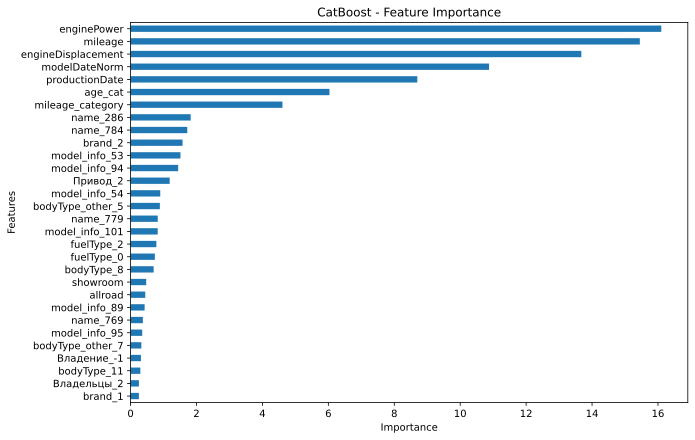

In [26]:
# check the significance of the features
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True,
                                                         False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

Из важных признаков видим и признаки, которые были даны изначально, а также те, которые Catboost сам сгенерировал из категориальных. Пока уменьшать размерность не буду. 

https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb - подбор гиперпараметров, лог лосс, кросс валидация

### Submission

In [89]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [ ]:
X_train.head(5)

## Simple Dense NN

In [27]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

In [28]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [29]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE',
    patience=50,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

### Fit

In [30]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,
    verbose=0,
)

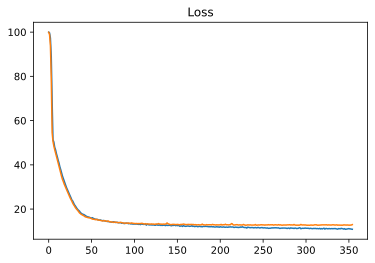

In [31]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [32]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [33]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.98%


На baseline TEST mape: 14.10%, улучшила до 13.67%. После того, как полностью обработала документ - 12.98%.

In [34]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:, 0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [35]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

Среднее количество символов 826.301448581348
Минимальное количество символов 1
Максимальное количество символов 10517


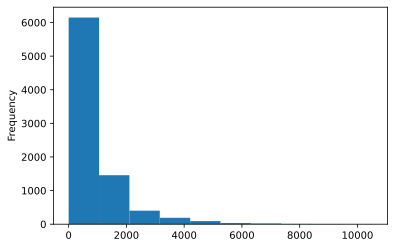

In [36]:
data['description_length'] = data.description.apply(len)
print("Среднее количество символов", data['description_length'].mean())
print("Минимальное количество символов", data['description_length'].min())
print("Максимальное количество символов", data['description_length'].max())

data['description_length'].plot.hist()

Большинство отзывов находятся в промежутке от 0 до 1000 символов. 

In [37]:
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


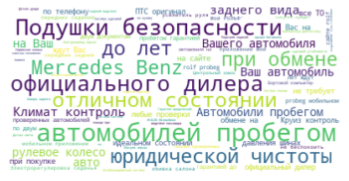

In [38]:
#  построим наиболее часто употребляемые слова
text = list(train.description.values)
worldcloud = WordCloud(max_words=100,
                       background_color="white",
                       stopwords=STOPWORDS).generate(str(text))
plt.imshow(worldcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Чаще всего в объвялении пишут о том, что автомобиль с пробегом, система (?), характеристики - обогрев, датчики, подушки, фары. Большое количество n - нужно их удалить. 

In [ ]:
# проверим, что \n не несет никакой смысловой нагрузки
data.description.loc[6678]

In [40]:
# убираем \n
regex = re.compile(r"\n")
data['description'] = data['description'].apply(lambda x: re.sub(regex, '', x))

In [ ]:
# проверяем
data.description.loc[6678]

In [39]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 289 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 11.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pymorphy2

In [42]:
# проведем лемматизацию
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"


def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [43]:
data['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [ ]:
data.description

In [ ]:
# убираем слишком короткие отзывы?
# data = data.loc[train['description_length'] > 15]

In [44]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [45]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [46]:
% % time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.65 s


In [ ]:
tokenize.word_index

In [48]:
% % time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(
    text_train_sequences.shape,
    text_test_sequences.shape,
    text_sub_sequences.shape,
)

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.53 s


In [49]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.• автомобиль проверить по 110 пунктам• автокредит по специальный ставка от 13,7%ауди центр север, официальный дилер audi, входящий в группа компания рольф и являться один из крупный дилер в европе, предлагать вы ряд услуга по покупка и продажа автомобиль с пробегом.ич протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер audi в россия и предоставлять клиент самый большой выбор автомобиль с пробег audi и другой марок.каждый автомобиль проходить тщательный диагностик и подготовку, и гарантировать находиться в отличный состоянии.чтоба убедиться в правильный выборе, у вы есть возможность пройти тест-драйв ― ознакомительный поездка на интересовать автомобиле.в смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести online презентация и в видеозвонок показать выбрать автомобиль.такж ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условиях. специалист компания подо

### RNN NLP

In [50]:
model_nlp = Sequential()
# model_nlp.add(L.InputLayer(shape=(MAX_SEQUENCE_LENGTH,), name="seq_description"))
model_nlp.add(L.Embedding(
    len(tokenize.word_index) + 1,
    MAX_SEQUENCE_LENGTH,
))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128, ))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [51]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [52]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

### Fit

In [53]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [54]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE',
    patience=10,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

In [66]:
history = model.fit(
    [text_train_sequences, X_train],
    y_train,
    batch_size=512,
    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=([text_test_sequences, X_test], y_test),
    callbacks=callbacks_list)

Epoch 1/500
12/12 [==============================] - 6s 465ms/step - loss: 99.9702 - MAPE: 99.9702 - val_loss: 99.6735 - val_MAPE: 99.6735
Epoch 2/500
12/12 [==============================] - 5s 388ms/step - loss: 97.2372 - MAPE: 97.2372 - val_loss: 87.6861 - val_MAPE: 87.6861
Epoch 3/500
12/12 [==============================] - 5s 380ms/step - loss: 67.0284 - MAPE: 67.0284 - val_loss: 54.8758 - val_MAPE: 54.8758
Epoch 4/500
12/12 [==============================] - 5s 416ms/step - loss: 52.1512 - MAPE: 52.1512 - val_loss: 48.2334 - val_MAPE: 48.2334
Epoch 5/500
12/12 [==============================] - 5s 388ms/step - loss: 47.1564 - MAPE: 47.1564 - val_loss: 44.5058 - val_MAPE: 44.5058
Epoch 6/500
12/12 [==============================] - 5s 394ms/step - loss: 43.5454 - MAPE: 43.5454 - val_loss: 41.2809 - val_MAPE: 41.2809
Epoch 7/500
12/12 [==============================] - 5s 392ms/step - loss: 40.0161 - MAPE: 40.0161 - val_loss: 37.2769 - val_MAPE: 37.2769
Epoch 8/500
12/12 [========

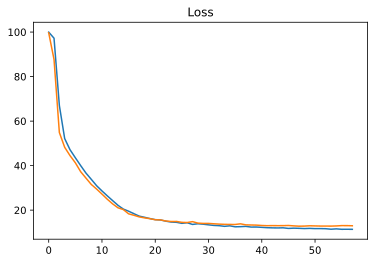

In [67]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [68]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [69]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.99%


Результат - TEST mape: 12.99%, на baseline - 14.88%.

In [70]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

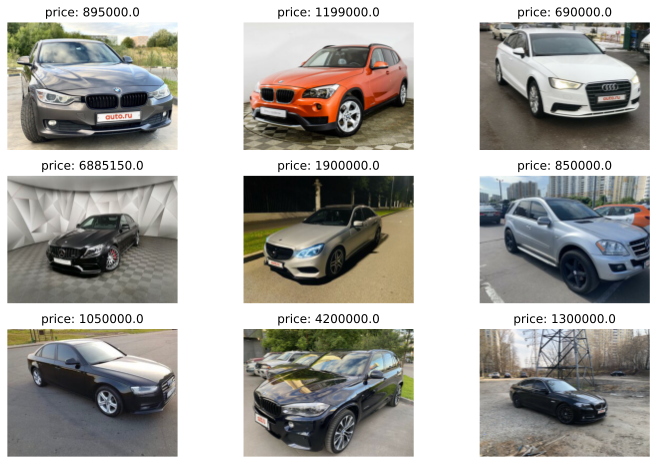

In [55]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [62]:
import cv2

size = (320, 240)


def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert (image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return (images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [57]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate,
                            CLAHE, RandomRotate90, Transpose, ShiftScaleRotate,
                            Blur, OpticalDistortion, GridDistortion,
                            HueSaturationValue, IAAAdditiveGaussianNoise,
                            GaussNoise, MotionBlur, MedianBlur,
                            IAAPiecewiseAffine, IAASharpen, IAAEmboss,
                            RandomBrightnessContrast, Flip, OneOf, Compose)

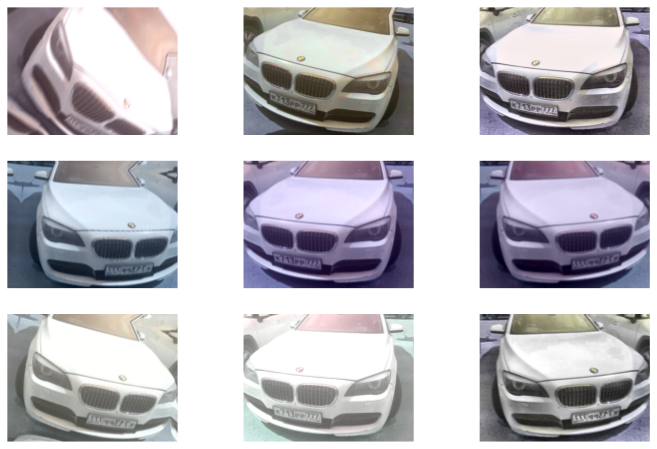

In [63]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(
        interpolation=1,
        border_mode=4,
        value=None,
        mask_value=None,
        always_apply=False,
        p=0.5,
    ),
    A.OneOf(
        [
            A.RandomBrightnessContrast(brightness_limit=0.3,
                                       contrast_limit=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.1,
                                       contrast_limit=0.1),
        ],
        p=0.5,
    ),
    A.GaussianBlur(p=0.05),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    #         A.Resize(IMG_SIZE, IMG_SIZE),
    A.OneOf(
        [
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.1),
        ],
        p=0.2,
    ),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.2,
                       rotate_limit=45,
                       p=0.2),
    A.OneOf(
        [
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
        ],
        p=0.2,
    ),
    A.OneOf(
        [
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ],
        p=0.3,
    ),
])

# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augmentation(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [64]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = augmentation(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [71]:
def process_image(image):
    return augmentation(image=image.numpy())['image']


def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions),
                                  maxlen=MAX_SEQUENCE_LENGTH)


def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [
        image,
    ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [
        text,
    ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices(
    (images_train, X_train, data.description.iloc[X_train.index],
     y_train)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (images_test, X_test, data.description.iloc[X_test.index],
     y_test)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices(
    (images_sub, X_sub, data.description.iloc[X_sub.index],
     y_sub)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

### Строим сверточную сеть для анализа изображений без "головы"

In [72]:
# нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [73]:
# строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape=X.shape[1]),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
])

In [74]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(
        len(tokenize.word_index) + 1,
        MAX_SEQUENCE_LENGTH,
    ),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
])

In [75]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1, )(head)

model = Model(
    inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input],
    outputs=head)
# model.summary()

In [76]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [77]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5',
                             monitor=['val_MAPE'],
                             verbose=0,
                             mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE',
    patience=10,
    restore_best_weights=True,
)
callbacks_list = [checkpoint, earlystop]

In [78]:
# рано остановился - на 34 эпохе - покрутить Адама? или patience?
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data=test_dataset.batch(30),
                    callbacks=callbacks_list)

Epoch 1/100
190/190 [==============================] - 149s 783ms/step - loss: 54.6766 - MAPE: 54.6766 - val_loss: 176983.2812 - val_MAPE: 176983.2812
Epoch 2/100
190/190 [==============================] - 145s 764ms/step - loss: 29.1700 - MAPE: 29.1700 - val_loss: 28.8619 - val_MAPE: 28.8619
Epoch 3/100
190/190 [==============================] - 145s 763ms/step - loss: 20.1323 - MAPE: 20.1323 - val_loss: 16.4837 - val_MAPE: 16.4837
Epoch 4/100
190/190 [==============================] - 145s 761ms/step - loss: 16.7111 - MAPE: 16.7111 - val_loss: 15.0133 - val_MAPE: 15.0133
Epoch 5/100
190/190 [==============================] - 145s 762ms/step - loss: 15.3423 - MAPE: 15.3423 - val_loss: 14.6304 - val_MAPE: 14.6304
Epoch 6/100
190/190 [==============================] - 144s 758ms/step - loss: 14.3756 - MAPE: 14.3756 - val_loss: 13.9801 - val_MAPE: 13.9801
Epoch 7/100
190/190 [==============================] - 144s 756ms/step - loss: 13.6642 - MAPE: 13.6642 - val_loss: 13.5815 - val_MAPE:

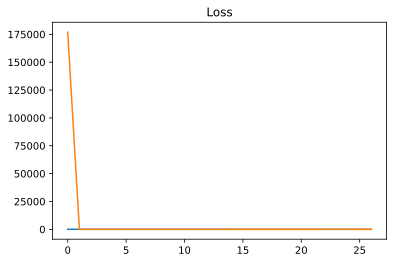

In [79]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [80]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [81]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.41%


In [82]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [83]:
blend_predict = (test_predict_catboost + test_predict_nn3[:, 0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.23%


In [90]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:, 0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [91]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [92]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(
    len(X.productionDate.unique().tolist()) + 1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [93]:
combinedInput = L.concatenate([
    model_mlp.output,
    f_productiondate,
])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [94]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [95]:
history = model.fit(
    [X_train, X_train.productionDate.values],
    y_train,
    batch_size=512,
    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
    validation_data=([X_test, X_test.productionDate.values], y_test),
    callbacks=callbacks_list)

Epoch 1/500
12/12 [==============================] - 1s 49ms/step - loss: 99.9859 - MAPE: 99.9859 - val_loss: 99.8349 - val_MAPE: 99.8349
Epoch 2/500
12/12 [==============================] - 0s 12ms/step - loss: 98.4573 - MAPE: 98.4573 - val_loss: 92.7215 - val_MAPE: 92.7215
Epoch 3/500
12/12 [==============================] - 0s 12ms/step - loss: 76.2128 - MAPE: 76.2128 - val_loss: 50.4335 - val_MAPE: 50.4335
Epoch 4/500
12/12 [==============================] - 0s 11ms/step - loss: 53.4563 - MAPE: 53.4563 - val_loss: 48.0639 - val_MAPE: 48.0639
Epoch 5/500
12/12 [==============================] - 0s 12ms/step - loss: 47.9378 - MAPE: 47.9378 - val_loss: 45.2144 - val_MAPE: 45.2144
Epoch 6/500
12/12 [==============================] - 0s 12ms/step - loss: 44.2545 - MAPE: 44.2545 - val_loss: 41.9009 - val_MAPE: 41.9009
Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 40.8357 - MAPE: 40.8357 - val_loss: 38.4125 - val_MAPE: 38.4125
Epoch 8/500
12/12 [===============

In [96]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 12.83%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c128a10f-2d55-4571-a30f-8e526420573b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>